## Introduction
Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data Preparation

In order to prepare the data for model training, multiple steps must be taken to ensure that it is compatible for this process. These steps include:
1) Remove any duplicate rows
2) Dropping features that will not impact car price directly. it is not likely that features such as when the app is accessed will directly impact car price. These will only add clutter to our data set and cause issues with model performance ('DateCrawled', 'DateCreated','NumberOfPictures', 'LastSeen')
3) Deal with missing values 
4) Changing postal code data so that it is easier to encode. Using it to isolate regions and keep regional data without making the postal codes difficult to encode or to cause overfitting.
5) Complete any necessary data type conversions/Encoding decisions

### Import Libraries and Data

In [1]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/datasets/car_data.csv')
display(df.info())
display(df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

None

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


In [3]:
#convert df to all lower case
#all data should be lower case to avoid issues
def convert_to_lower(df):
    for column in df.columns:
        if df[column].dtype == 'object':
            if df[column].str.contains('[A-Z]').any():
                df[column] = df[column].str.lower()
    return df
df = convert_to_lower(df)
df.columns = df.columns.str.replace(r'(?<!^)(?=[A-Z])', '_', regex=True).str.lower()

### Duplicate Rows

In [4]:
#drop duplicate rows
num_duplicates = df.duplicated().sum()
print(f"There are {num_duplicates} duplicated rows in the data frame.")

df = df.drop_duplicates()
num_duplicates2 = df.duplicated().sum()
print(f"There are now {num_duplicates2} duplicated rows in the data frame.")
print(df.info())

There are 262 duplicated rows in the data frame.
There are now 0 duplicated rows in the data frame.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 354107 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354107 non-null  object
 1   price               354107 non-null  int64 
 2   vehicle_type        316623 non-null  object
 3   registration_year   354107 non-null  int64 
 4   gearbox             334277 non-null  object
 5   power               354107 non-null  int64 
 6   model               334406 non-null  object
 7   mileage             354107 non-null  int64 
 8   registration_month  354107 non-null  int64 
 9   fuel_type           321218 non-null  object
 10  brand               354107 non-null  object
 11  not_repaired        282962 non-null  object
 12  date_created        354107 non-null  object
 13  number_of_pictures  354107 non-null  int64 
 14  

### Feature Dropping

In [5]:
#registration_year CANNOT be after date_crawled
df['date_crawled'] = pd.to_datetime(df['date_crawled'], format='%d/%m/%Y %H:%M')
df['date_crawled_year'] = df['date_crawled'].dt.year
df['date_crawled_month'] = df['date_crawled'].dt.month
df = df[~((df['registration_year'] > df['date_crawled_year']) | 
          ((df['registration_year'] == df['date_crawled_year']) & 
           (df['registration_month'] > df['date_crawled_month'])))]

#dropping features that do no impact car price
columns_to_drop = ['date_crawled', 'date_created','number_of_pictures', 'last_seen']
dropped_df = df[columns_to_drop].copy()
df = df.drop(columns=columns_to_drop)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 334351 entries, 0 to 354368
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               334351 non-null  int64 
 1   vehicle_type        316574 non-null  object
 2   registration_year   334351 non-null  int64 
 3   gearbox             316868 non-null  object
 4   power               334351 non-null  int64 
 5   model               317363 non-null  object
 6   mileage             334351 non-null  int64 
 7   registration_month  334351 non-null  int64 
 8   fuel_type           309160 non-null  object
 9   brand               334351 non-null  object
 10  not_repaired        271672 non-null  object
 11  postal_code         334351 non-null  int64 
 12  date_crawled_year   334351 non-null  int64 
 13  date_crawled_month  334351 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 38.3+ MB
None


### Missing Values

In [6]:
#dealing with missing values
#VehicleType column
print(df['vehicle_type'].nunique())
print(df['vehicle_type'].isna().sum())
df['vehicle_type'] = df['vehicle_type'].fillna('not_listed')
print(df.info())

8
17777
<class 'pandas.core.frame.DataFrame'>
Int64Index: 334351 entries, 0 to 354368
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               334351 non-null  int64 
 1   vehicle_type        334351 non-null  object
 2   registration_year   334351 non-null  int64 
 3   gearbox             316868 non-null  object
 4   power               334351 non-null  int64 
 5   model               317363 non-null  object
 6   mileage             334351 non-null  int64 
 7   registration_month  334351 non-null  int64 
 8   fuel_type           309160 non-null  object
 9   brand               334351 non-null  object
 10  not_repaired        271672 non-null  object
 11  postal_code         334351 non-null  int64 
 12  date_crawled_year   334351 non-null  int64 
 13  date_crawled_month  334351 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 38.3+ MB
None


In [7]:
#Missing Values, Gearbox Column
print(df['gearbox'].nunique())
print(df['gearbox'].isna().sum())
df['gearbox'] = df['gearbox'].fillna('not_listed')
print(df.info())

2
17483
<class 'pandas.core.frame.DataFrame'>
Int64Index: 334351 entries, 0 to 354368
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               334351 non-null  int64 
 1   vehicle_type        334351 non-null  object
 2   registration_year   334351 non-null  int64 
 3   gearbox             334351 non-null  object
 4   power               334351 non-null  int64 
 5   model               317363 non-null  object
 6   mileage             334351 non-null  int64 
 7   registration_month  334351 non-null  int64 
 8   fuel_type           309160 non-null  object
 9   brand               334351 non-null  object
 10  not_repaired        271672 non-null  object
 11  postal_code         334351 non-null  int64 
 12  date_crawled_year   334351 non-null  int64 
 13  date_crawled_month  334351 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 38.3+ MB
None


In [8]:
#Missing Values, Model column
print(df['model'].nunique())
print(df['model'].isna().sum())
df['model'] = df['model'].fillna('not_listed')
print(df.info())

250
16988
<class 'pandas.core.frame.DataFrame'>
Int64Index: 334351 entries, 0 to 354368
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               334351 non-null  int64 
 1   vehicle_type        334351 non-null  object
 2   registration_year   334351 non-null  int64 
 3   gearbox             334351 non-null  object
 4   power               334351 non-null  int64 
 5   model               334351 non-null  object
 6   mileage             334351 non-null  int64 
 7   registration_month  334351 non-null  int64 
 8   fuel_type           309160 non-null  object
 9   brand               334351 non-null  object
 10  not_repaired        271672 non-null  object
 11  postal_code         334351 non-null  int64 
 12  date_crawled_year   334351 non-null  int64 
 13  date_crawled_month  334351 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 38.3+ MB
None


In [9]:
#Missing Values, FuelType column
print(df['fuel_type'].nunique())
print(df['fuel_type'].isna().sum())
df['fuel_type'] = df['fuel_type'].fillna('not_listed')
print(df.info())

7
25191
<class 'pandas.core.frame.DataFrame'>
Int64Index: 334351 entries, 0 to 354368
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               334351 non-null  int64 
 1   vehicle_type        334351 non-null  object
 2   registration_year   334351 non-null  int64 
 3   gearbox             334351 non-null  object
 4   power               334351 non-null  int64 
 5   model               334351 non-null  object
 6   mileage             334351 non-null  int64 
 7   registration_month  334351 non-null  int64 
 8   fuel_type           334351 non-null  object
 9   brand               334351 non-null  object
 10  not_repaired        271672 non-null  object
 11  postal_code         334351 non-null  int64 
 12  date_crawled_year   334351 non-null  int64 
 13  date_crawled_month  334351 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 38.3+ MB
None


In [10]:
#Missing Values, NotRepaired column
print(df['not_repaired'].nunique())
print(df['not_repaired'].isna().sum())
df['not_repaired'] = df['not_repaired'].fillna('not_listed')
print(df.info())

2
62679
<class 'pandas.core.frame.DataFrame'>
Int64Index: 334351 entries, 0 to 354368
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               334351 non-null  int64 
 1   vehicle_type        334351 non-null  object
 2   registration_year   334351 non-null  int64 
 3   gearbox             334351 non-null  object
 4   power               334351 non-null  int64 
 5   model               334351 non-null  object
 6   mileage             334351 non-null  int64 
 7   registration_month  334351 non-null  int64 
 8   fuel_type           334351 non-null  object
 9   brand               334351 non-null  object
 10  not_repaired        334351 non-null  object
 11  postal_code         334351 non-null  int64 
 12  date_crawled_year   334351 non-null  int64 
 13  date_crawled_month  334351 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 38.3+ MB
None


In [11]:
#Remove rows with multiple values not listed
not_listed_counts = (df == 'not_listed').sum(axis=1)
df = df[not_listed_counts < 2]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304290 entries, 1 to 354368
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               304290 non-null  int64 
 1   vehicle_type        304290 non-null  object
 2   registration_year   304290 non-null  int64 
 3   gearbox             304290 non-null  object
 4   power               304290 non-null  int64 
 5   model               304290 non-null  object
 6   mileage             304290 non-null  int64 
 7   registration_month  304290 non-null  int64 
 8   fuel_type           304290 non-null  object
 9   brand               304290 non-null  object
 10  not_repaired        304290 non-null  object
 11  postal_code         304290 non-null  int64 
 12  date_crawled_year   304290 non-null  int64 
 13  date_crawled_month  304290 non-null  int64 
dtypes: int64(8), object(6)
memory usage: 34.8+ MB
None


In [12]:
#isolate regions using postal code data
df['region'] = df['postal_code'].astype(str).str[:2]
#drop postal code column
df = df.drop(['postal_code'], axis=1)
print(df.info())
display(df.head(5))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 304290 entries, 1 to 354368
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               304290 non-null  int64 
 1   vehicle_type        304290 non-null  object
 2   registration_year   304290 non-null  int64 
 3   gearbox             304290 non-null  object
 4   power               304290 non-null  int64 
 5   model               304290 non-null  object
 6   mileage             304290 non-null  int64 
 7   registration_month  304290 non-null  int64 
 8   fuel_type           304290 non-null  object
 9   brand               304290 non-null  object
 10  not_repaired        304290 non-null  object
 11  date_crawled_year   304290 non-null  int64 
 12  date_crawled_month  304290 non-null  int64 
 13  region              304290 non-null  object
dtypes: int64(7), object(7)
memory usage: 34.8+ MB
None


,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,not_repaired,date_crawled_year,date_crawled_month,region
1,18300,coupe,2011,manual,190,not_listed,125000,5,gasoline,audi,yes,2016,3,66
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,not_listed,2016,3,90
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016,3,91
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016,3,60
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016,4,33


In [13]:
print(df.describe())

               price  registration_year          power        mileage  \
count  304290.000000      304290.000000  304290.000000  304290.000000   
mean     4744.731789        2002.461819     116.393217  128367.034737   
std      4609.905391           6.456546     185.523362   36834.110313   
min         0.000000        1600.000000       0.000000    5000.000000   
25%      1250.000000        1999.000000      75.000000  125000.000000   
50%      3000.000000        2003.000000     109.000000  150000.000000   
75%      6900.000000        2007.000000     145.000000  150000.000000   
max     20000.000000        2016.000000   20000.000000  150000.000000   

       registration_month  date_crawled_year  date_crawled_month  
count       304290.000000           304290.0       304290.000000  
mean             6.004351             2016.0            3.163288  
std              3.586195                0.0            0.369629  
min              0.000000             2016.0            3.000000  
25%    

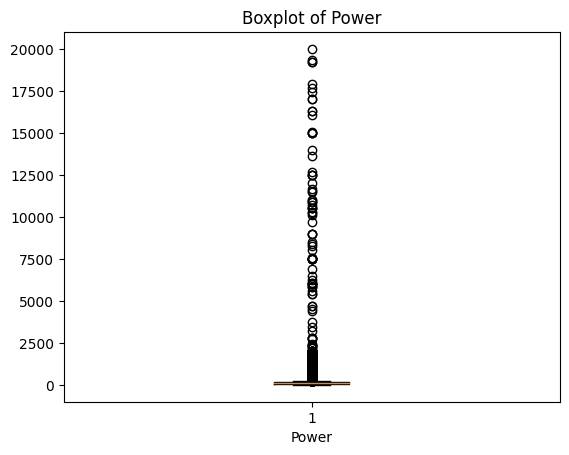

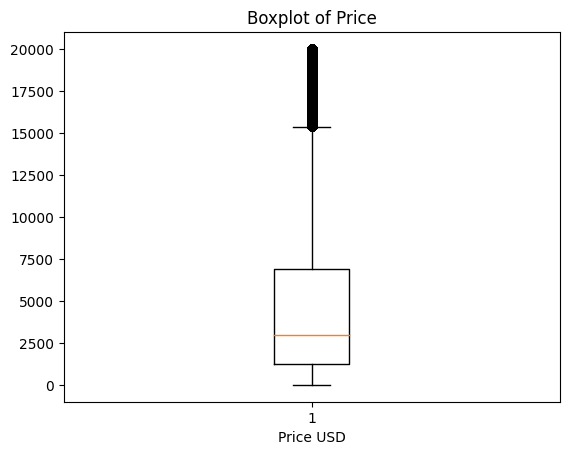

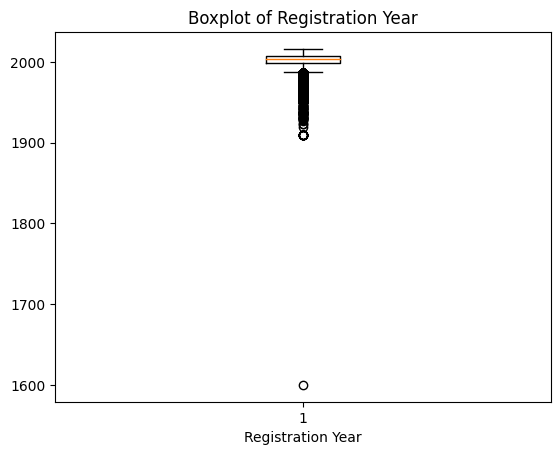

In [14]:
#visualize outlier columns
plt.boxplot(df['power'])
plt.title('Boxplot of Power')
plt.xlabel('Power')
plt.show()

plt.boxplot(df['price'])
plt.title('Boxplot of Price')
plt.xlabel('Price USD')
plt.show()

plt.boxplot(df['registration_year'])
plt.title('Boxplot of Registration Year')
plt.xlabel('Registration Year')
plt.show()

### Outlier Modification

1) For power: Cars with extrememely low power or extrememly high levels of power are removed as they are unrealistic in a real life context and were probably entered incorrectly.
2) Price outliers that represent exrtremely low values or extremely high values indicate errors, completely broken cars, or luxury vehicles which could negatively impact model performance.
3) registration years that do not make sense. No car can be registered later than 2025. Cars before 1990 were dropped to encompass a majority of the data and remove any cars that could be considered "antique". These niche cases could impact model performance.


In [15]:
#drop outliers
#remove entries where power is unrealistic
df = df[(df['power'] > 20) & (df['power'] < 1000)]

#remove price outliers
df = df[(df['price'] >= df['price'].quantile(0.05)) & 
        (df['price'] <= df['price'].quantile(0.95))]

#drop registration year outliers 
df = df[(df['registration_year'] >= df['registration_year'].quantile(0.01)) & 
        (df['registration_year'] <= df['registration_year'].quantile(0.99))]
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252435 entries, 2 to 354368
Data columns (total 14 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               252435 non-null  int64 
 1   vehicle_type        252435 non-null  object
 2   registration_year   252435 non-null  int64 
 3   gearbox             252435 non-null  object
 4   power               252435 non-null  int64 
 5   model               252435 non-null  object
 6   mileage             252435 non-null  int64 
 7   registration_month  252435 non-null  int64 
 8   fuel_type           252435 non-null  object
 9   brand               252435 non-null  object
 10  not_repaired        252435 non-null  object
 11  date_crawled_year   252435 non-null  int64 
 12  date_crawled_month  252435 non-null  int64 
 13  region              252435 non-null  object
dtypes: int64(7), object(7)
memory usage: 28.9+ MB
None


In [16]:
#drop specified columns from the DataFrame
df = df.drop(columns=["registration_month", "date_crawled_year", "date_crawled_month"])

In [17]:
#drop duplicates after column deletion
num_duplicates3 = df.duplicated().sum()
print(f"There are {num_duplicates3} duplicated rows in the data frame.")

df = df.drop_duplicates()
num_duplicates4 = df.duplicated().sum()
print(f"There are now {num_duplicates4} duplicated rows in the data frame.")
print(df.info())

There are 19793 duplicated rows in the data frame.
There are now 0 duplicated rows in the data frame.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 232642 entries, 2 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              232642 non-null  int64 
 1   vehicle_type       232642 non-null  object
 2   registration_year  232642 non-null  int64 
 3   gearbox            232642 non-null  object
 4   power              232642 non-null  int64 
 5   model              232642 non-null  object
 6   mileage            232642 non-null  int64 
 7   fuel_type          232642 non-null  object
 8   brand              232642 non-null  object
 9   not_repaired       232642 non-null  object
 10  region             232642 non-null  object
dtypes: int64(4), object(7)
memory usage: 21.3+ MB
None


In [18]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232642 entries, 2 to 354368
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   price              232642 non-null  int64 
 1   vehicle_type       232642 non-null  object
 2   registration_year  232642 non-null  int64 
 3   gearbox            232642 non-null  object
 4   power              232642 non-null  int64 
 5   model              232642 non-null  object
 6   mileage            232642 non-null  int64 
 7   fuel_type          232642 non-null  object
 8   brand              232642 non-null  object
 9   not_repaired       232642 non-null  object
 10  region             232642 non-null  object
dtypes: int64(4), object(7)
memory usage: 21.3+ MB
None


### Encoding Decisions

In [19]:
df_encoded = pd.get_dummies(df, columns=['vehicle_type', 'gearbox', 'model','fuel_type', 'brand', 'not_repaired', 'region'], drop_first=True)
print(df_encoded.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 232642 entries, 2 to 354368
Columns: 398 entries, price to region_99
dtypes: int64(4), uint8(394)
memory usage: 96.3 MB
None


In [20]:
#create test and training sets for encoded and not encoded data
#split into features/target sets
#not encoded data
X= df.drop(['price'], axis=1)
y= df['price']

#encoded data
Xe= df_encoded.drop(['price'], axis=1)
ye= df_encoded['price']

In [21]:
#split encoded data into test, train, and validation sets
Xe_train, Xe_temp, ye_train, ye_temp = train_test_split(
    Xe, ye, test_size=0.4, random_state=123)

#second split
Xe_val, Xe_test, ye_val, ye_test = train_test_split(
    Xe_temp, ye_temp, test_size=0.5, random_state=123)

print(f"Xe_train shape: {Xe_train.shape}, ye_train shape: {ye_train.shape}")
print(f"Xe_val shape: {Xe_val.shape}, ye_val shape: {ye_val.shape}")
print(f"Xe_test shape: {Xe_test.shape}, ye_test shape: {ye_test.shape}")

Xe_train shape: (139585, 397), ye_train shape: (139585,)
Xe_val shape: (46528, 397), ye_val shape: (46528,)
Xe_test shape: (46529, 397), ye_test shape: (46529,)


## Model Training

### RandomForest Model - Encoded Data

In [ ]:
%%time
#model definition and (randomizedsearchCV)
rf_model = RandomForestRegressor(random_state=123)

#set up the hyperparameter grid
param_dist = {
    'n_estimators': [50, 75, 100],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

#randomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=25,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    n_jobs=-1,
    random_state=123
)

In [ ]:
%%time
#hyperparameter tuning/fit data/train model
random_search.fit(Xe_train, ye_train)

In [ ]:
%%time
#best model and calculations on validation set
best_rf = random_search.best_estimator_
ye_pred = best_rf.predict(Xe_val)
rf_rmse = np.sqrt(mean_squared_error(ye_val, ye_pred))
print(f"The RMSE for the RandomForest Regressor model on the validation set is {rf_rmse}.")

### LightGBM Model

In [ ]:
%%time
#model definition and (randomizedsearchCV)
lgb_model = lgb.LGBMRegressor(random_state=123)
param_dist = {
    'num_leaves': [31, 50, 70],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 300]
    
}

#randomizedSearchCV with limited combinations
random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=10,
    cv=3,
    scoring='neg_root_mean_squared_error',
    verbose=2,
    random_state=123,
    n_jobs=-1
)

In [ ]:
%%time
#hyperparameter tuning/fit data/train model
random_search.fit(Xe_train, ye_train)

In [ ]:
%%time
#best model and calculate RMSE score
best_lgb = random_search.best_estimator_
y_pred_lgb = best_lgb.predict(Xe_val)
lgb_rmse = np.sqrt(mean_squared_error(ye_val, y_pred_lgb))
print(f"The RMSE for the LightGBM model on the validation data is {lgb_rmse}.")

### Base Line Model: Linnear Regression - Encoded Data

In [ ]:
%%time
#define model
lr_model= LinearRegression()

In [ ]:
%%time
#train model 
lr_model = lr_model.fit(Xe_train,ye_train)

In [ ]:
%%time
#calculate RMSE score
lr_pred = lr_model.predict(Xe_test)
lr_mse = mean_squared_error(ye_test, lr_pred)
lr_rmse = np.sqrt(lr_mse)
print(f"The RMSE for the Linnear Regression model is {lr_rmse}.")

### Run Best Performing Model on Test Data: LightGBM

In [ ]:
%%time
##run LightGBM model on test data
#calculate RMSE score
best_lgb = random_search.best_estimator_
y_pred_lgb_final = best_lgb.predict(Xe_test)
lgb_rmse_final = np.sqrt(mean_squared_error(ye_test, y_pred_lgb_final))
print(f"The RMSE for the LightGBM model is {lgb_rmse_final}.")

## Model analysis

In this project, three different models were tuned to optimize performance, trained on a training data set, and tested on a validation data set. Each model was assesed for the lowest RMSE and highest speed. 

All of the models were able to predict the validation data set and calculate the RMSE score in less than five seconds. So when comparing model speeds, looking at hyperparameter tuning, the longest part of the process, gives more insight into difference in model run time. 

The RandomForestRegressor model took the longest amount of time to tune its hyperparameters (wall time: 35 minutes 13 seconds). On the validation data set, it produced an RMSE value of 1283.4359135336733.

The LightGBM model used gradient boosting methods and was signifigantly quicker during hyperparameter tuning (wall time 2 minutes 23 seconds). On the validation set, it produced an RMSE value of 1273.04806354423.

Both of these models were compared to a Linear Regression model. This model ran quickly (just over 1 minute from model creation to RMSE calculation total). However on the validation set, it produced the highest RMSE value of 1898.2686518542014.

Given that the LightGBM model produced the most accurate results and was relatively fast compared to the RandomForest Regression model, this model makes the most sense to use for used car sales predictions. This model has the ability to predict used car values in a moderately fast amount of time, which will appeal to customers using the Rusty Bargain app. On the test data set, the LightGBM model predicted the results with an RMSE score of 1277.0534915036728 and did it with a wall time of 1.34 seconds! Not bad!

Overall I would suggest the LightGBM model to Rusty Bargain to predict sales in used cars, as it produced the most accurate results in a moderately fast amount of time. 

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [x ]  Code is error free
- [x ]  The cells with the code have been arranged in order of execution
- [x ]  The data has been downloaded and prepared
- [x ]  The models have been trained
- [x ]  The analysis of speed and quality of the models has been performed